In [1]:
# The code for this assignment can be found at: 
# https://github.com/Owenx25/UT_AiInHealthcare/blob/main/Mimic_Visualizations/assignment2.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px

DATA_PATH = '' # Path to the data folder containing all mimiciii CSV files

In [46]:
# Load admissions data
admissions = pd.read_csv(f'{DATA_PATH}/ADMISSIONS.csv') 

# Load diagnoses data
diagnoses = pd.read_csv(f'{DATA_PATH}/DIAGNOSES_ICD.csv') 

# Load patients data
patients = pd.read_csv(f'{DATA_PATH}/PATIENTS.csv') 

# Load icustays data
icustays = pd.read_csv(f'{DATA_PATH}/ICUSTAYS.csv')

prescriptions = pd.read_csv(f"{DATA_PATH}/PRESCRIPTIONS.csv")


/var/folders/50/ps11njl93r52n622qd1nd_h80000gn/T/ipykernel_47013/1066506663.py:13: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



## Visualization 1: Admissions Trends during Seasons


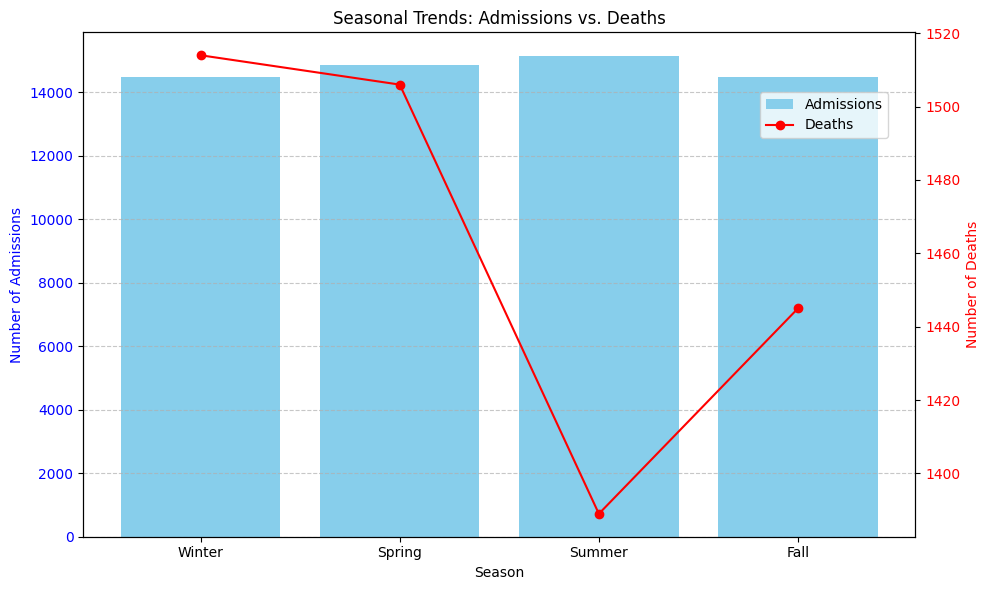

In [3]:
# Convert timestamps to datetime
admissions['admittime'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['deathtime'] = pd.to_datetime(admissions['DEATHTIME'])

# Extract month and define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

admissions['admitmonth'] = admissions['admittime'].dt.month
admissions['deathmonth'] = admissions['deathtime'].dt.month
admissions['admitseason'] = admissions['admitmonth'].apply(get_season)
admissions['deathseason'] = admissions['deathmonth'].apply(get_season)

# Group by season for admissions
admissions_by_season = admissions.groupby('admitseason').size()

# Filter and group by season for deaths
deaths_data = admissions[admissions['deathtime'].notna()]
deaths_by_season = deaths_data.groupby('deathseason').size()

# Align seasons in proper order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
admissions_by_season = admissions_by_season.reindex(season_order)
deaths_by_season = deaths_by_season.reindex(season_order)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for admissions
ax1.bar(admissions_by_season.index, admissions_by_season.values, color='skyblue', label='Admissions')
ax1.set_xlabel('Season')
ax1.set_ylabel('Number of Admissions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for deaths
ax2 = ax1.twinx()
ax2.plot(deaths_by_season.index, deaths_by_season.values, color='red', marker='o', label='Deaths')
ax2.set_ylabel('Number of Deaths', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Seasonal Trends: Admissions vs. Deaths')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))

plt.tight_layout()
plt.show()

## Visualization 2: Diagnosis Word cloud 

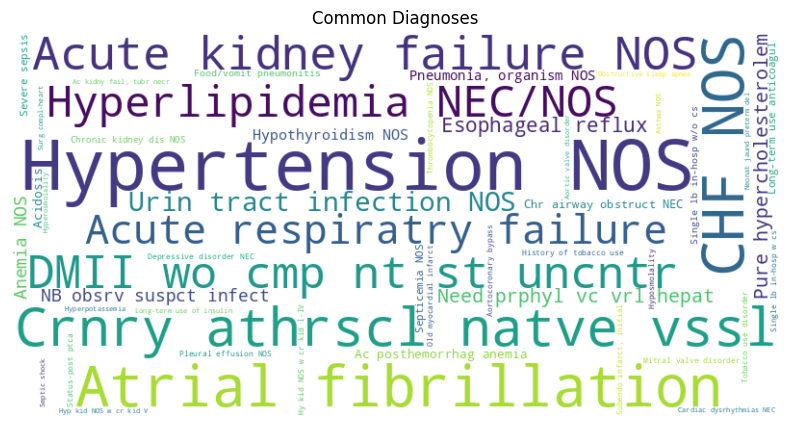

In [4]:
d_diagnoses = pd.read_csv(f'{DATA_PATH}/D_ICD_DIAGNOSES.csv')
diagnoses['ICD9_CODE'] = diagnoses['ICD9_CODE'].astype(str)
d_diagnoses['ICD9_CODE'] = d_diagnoses['ICD9_CODE'].astype(str)
diagnoses_with_codes = pd.merge(diagnoses, d_diagnoses, how='left', on='ICD9_CODE')

diag_dict = diagnoses_with_codes.groupby('SHORT_TITLE').size().nlargest(50).to_dict()

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    prefer_horizontal=0.40,
    colormap='viridis',  # Color scheme
    stopwords=None  # Optional: Use a set of custom stopwords
).generate_from_frequencies(diag_dict)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis lines
plt.title("Common Diagnoses")
plt.show()

## Visualization 2B: Items commonly used in procedures

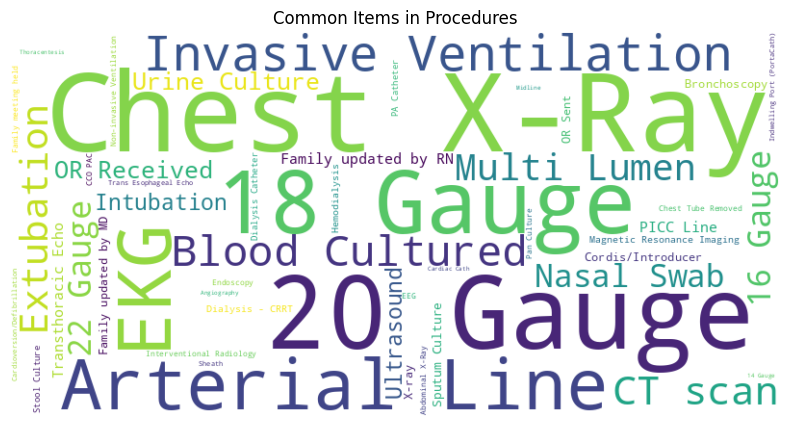

In [5]:
procedures = pd.read_csv(f'{DATA_PATH}/PROCEDUREEVENTS_MV.csv')
d_items = pd.read_csv(f'{DATA_PATH}/D_ITEMS.csv')
procedures_with_items = pd.merge(procedures, d_items, how='left', on='ITEMID')

item_dict = procedures_with_items.groupby('LABEL').size().nlargest(50).to_dict()

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    prefer_horizontal=0.40,
    colormap='viridis',  # Color scheme
    stopwords=None  # Optional: Use a set of custom stopwords
).generate_from_frequencies(item_dict)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis lines
plt.title("Common Items in Procedures")
plt.show()

## Visualization 3: Top drugs and dosages

In [51]:
NUM_TOP_DRUGS = 3
NUM_DOSES = 3

# Extract relevant columns
p_data = prescriptions[['DRUG', 'DOSE_VAL_RX', 'DOSE_UNIT_RX']]

# Drop rows with missing or invalid data
p_data = p_data.dropna(subset=['DRUG', 'DOSE_VAL_RX', 'DOSE_UNIT_RX'])
p_data['DOSE_VAL_RX'] = pd.to_numeric(p_data['DOSE_VAL_RX'], errors='ignore')  # Ensure dose is numeric
p_data = p_data.dropna(subset=['DOSE_VAL_RX'])

# Make mL case-insensitive
p_data['DOSE'] = p_data['DOSE_VAL_RX'] + ' ' + p_data['DOSE_UNIT_RX'].str.lower()
p_data['DOSE'] = p_data['DOSE'].str.lower()

# Identify the top N drugs
grouped_data = p_data.groupby(['DRUG', 'DOSE']).size().reset_index(name='Frequency')
top_drugs = grouped_data.groupby('DRUG')['Frequency'].sum().nlargest(NUM_TOP_DRUGS).index

# For top N drugs, get the top N doses
filtered_data = grouped_data[grouped_data['DRUG'].isin(top_drugs)]
filtered_data = (
    filtered_data.sort_values(['DRUG', 'Frequency'], ascending=[True, False])
    .groupby('DRUG')
    .head(NUM_DOSES)
)
filtered_data

/var/folders/50/ps11njl93r52n622qd1nd_h80000gn/T/ipykernel_47013/48577002.py:9: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



DRUG     DOSE  Frequency
5605                  D5W   250 ml      85991
5544                  D5W   100 ml      18834
5636                  D5W    50 ml      10743
11162             Insulin   0 unit      82073
11177             Insulin  10 unit       9041
11218             Insulin  20 unit       5737
20052  Potassium Chloride   40 meq      90801
20033  Potassium Chloride   20 meq      55085
20067  Potassium Chloride   60 meq      25096

In [49]:
# Create a Sankey diagram
drugs = list(filtered_data['DRUG'].unique())
doses = list(filtered_data['DOSE'].unique())
nodes = drugs + list(filtered_data['DOSE'].unique())
source = filtered_data['DRUG'].apply(lambda x: nodes.index(x))
target = filtered_data['DOSE'].apply(lambda x: nodes.index(x))
value = filtered_data['Frequency']
# print(nodes)
# print(source)
print(target)
print(len(drugs))
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

# Add layout details
fig.update_layout(
    title_text=f"Top {NUM_TOP_DRUGS} Drug Prescriptions and Their Dosages",
    font_size=10
)

# Show the figure
fig.show()

5605      3
5544      4
5636      5
11162     6
11177     7
11218     8
20052     9
20033    10
20067    11
Name: DOSE, dtype: int64
3


## Visualization 4: Age vs Average ICU stay time Split by Gender

In [90]:
filtered_icu = icustays[['LOS', 'SUBJECT_ID', 'INTIME']].dropna()
filtered_icu['INTIME'] = pd.to_datetime(filtered_icu['INTIME'])
filtered_patient = patients[['SUBJECT_ID', 'GENDER', 'DOB']].dropna()
filtered_patient['DOB'] = pd.to_datetime(filtered_patient['DOB'])

# Merge the dataframes
merged = pd.merge(filtered_icu, filtered_patient, on='SUBJECT_ID')
merged['age'] = merged['INTIME'].dt.year - merged['DOB'].dt.year
# limit to patients 89 and younger and older than 1
merged = merged[(merged['age'] <= 89) & (merged['age'] >= 1)]
fig = px.histogram(merged, x="age", color="GENDER", marginal="violin", # can be `box`, `violin`
                         hover_data=merged.columns)
# Add layout details
fig.update_layout(
    title_text=f"ICU Stay Patient Age",
    font_size=10
)
fig.show()

## Visualization 5: Vitals of a 66yo patient throughout their ICU stay

In [36]:
chunk_size = 100000  # Adjust based on available memory

filtered_chunks = []
# Stream the CSV file in chunks
for chunk in pd.read_csv(f"{DATA_PATH}/CHARTEVENTS.csv", chunksize=chunk_size):
    filtered_chunk = chunk[chunk['SUBJECT_ID'] == 99999]
    filtered_chunks.append(filtered_chunk)

# Combine only the filtered rows
filtered_chartevents = pd.concat(filtered_chunks, ignore_index=True)

/var/folders/50/ps11njl93r52n622qd1nd_h80000gn/T/ipykernel_47013/1425505042.py:5: DtypeWarning:

Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.



In [44]:
vital_map = {220045: 'Heart Rate (bpm)', 220210: 'Respiratory Rate (insp/min)', 220277: 'O2 saturation (%)', 220180: 'NBP systolic (mmHg)', 220179: "NBP diastolic (mmHg)", 223761: 'Temperature (F)'}
vitalIds = list(vital_map.keys())   

filtered_vitals = filtered_chartevents[filtered_chartevents['ITEMID'].isin(vitalIds)]
filtered_vitals = filtered_vitals.dropna(subset=['VALUENUM'])

filtered_vitals = filtered_vitals[['CHARTTIME', 'VALUENUM', 'ITEMID']]
filtered_vitals['VITAL'] = filtered_vitals['ITEMID'].map(vital_map)
filtered_vitals.drop(columns=['ITEMID'], inplace=True)
filtered_vitals = filtered_vitals.sort_values('CHARTTIME')
filtered_vitals = filtered_vitals.set_index('CHARTTIME')

filtered_vitals

fig = px.area(filtered_vitals,color="VITAL" , facet_col="VITAL", facet_col_wrap=2)
fig.show()